# Visualization & Plot maker
This notebook loads the results and visualizes them. The outputs of this notebook are plots located in the "../plots" directory for the paper and presentation.


## Load Results

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Load the CSV file into a pandas DataFrame
from datetime import datetime
import numpy as np
import matplotlib.ticker as ticker

from src.logs.load_utils import *

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({"xtick.labelsize": 17, "ytick.labelsize": 17,
"axes.titlesize": 18, "axes.titleweight": 'bold', "axes.labelsize": 19, "axes.labelweight": 'bold'})
pd.set_option('display.max_columns', 50)


In [15]:
cols = ['total_weights','model_name', 'dataset_name','regularization', 'regularization_param','optimizer_name',
 'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy','lr', "epoch_test_losses",'path'] + [f'bit_{i}_test_accuracy' for i in [16, 8, 4, 2]]
df = load_dataframe(columns = None)
df.shape

(38, 48)

## Accuracy Heatmaps

In [37]:
def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel=True, set_xlabel=True, 
                 model_name='', dataset_name='', title="", show_cbar=True):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}

    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws if show_cbar else None, 
                ax=ax, cbar=show_cbar)

    rename_dict = {'bit_2': '2-bit', 'bit_4': '4-bit', 'bit_16': '16-bit', 'bit_32': '32-bit', 'bit_8': "8-bit"}
    rename_model_name = {'resnet18':'ResNet-18','resnet20':'ResNet-20','lenet':"LeNet"}
    ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
    if set_ylabel:
        ax.set_yticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], rotation=0)
        ax.set_ylabel(f"{rename_model_name[model_name]}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    if not set_xlabel:
        ax.set_xlabel('')
    if title:
        ax.set_title(title, fontsize=25)

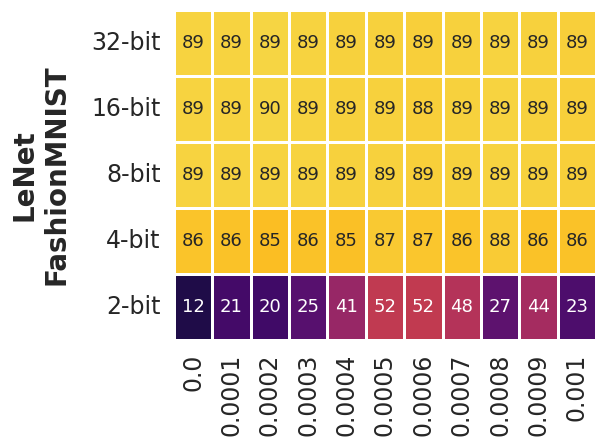

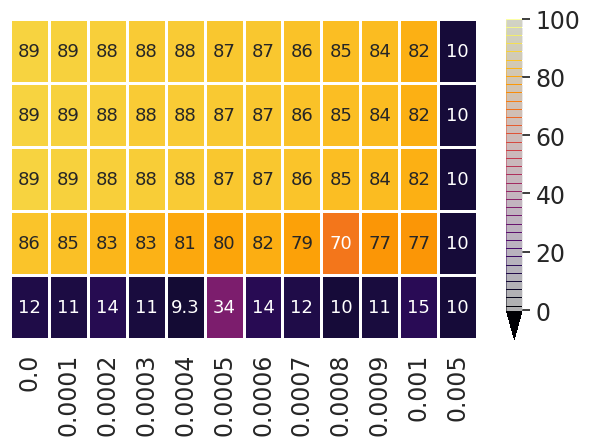

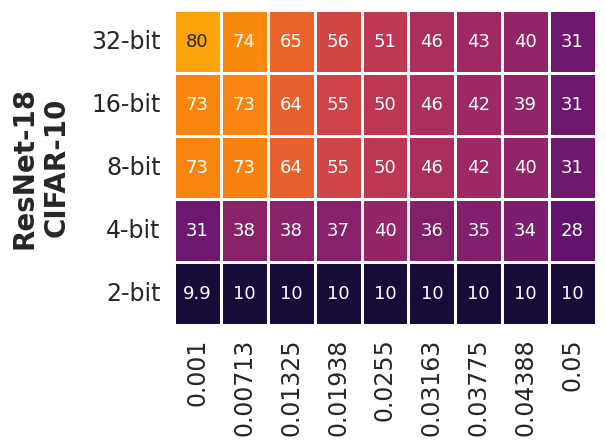

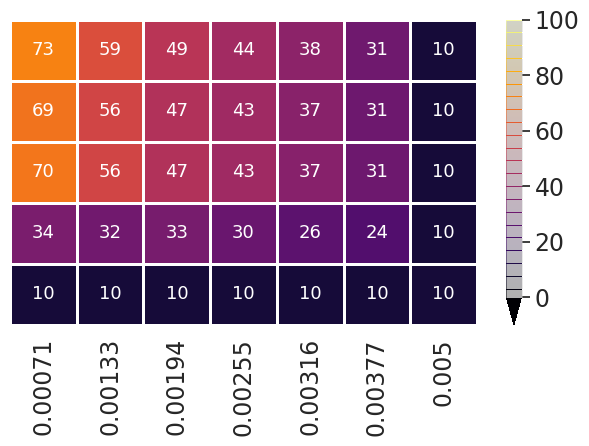

In [38]:
metric = 'test_accuracy'
unique_datasets = df['dataset_name'].drop_duplicates().dropna()

for dataset_name in unique_datasets:
    unique_pairs = df[df['dataset_name'] == dataset_name][['model_name', 'regularization']].drop_duplicates().dropna()

    # Updated number of plots (subplots) needed for this dataset
    n_plots = len(unique_pairs)

    # Create a figure with multiple subplots
    titles = {"l2": "Weight Decay", "l1": 'Lasso'}
    for i, (model_name, regularization) in enumerate(unique_pairs.values):
        if regularization != "none":
            fig, ax = plt.subplots()

            tmp = df[
                (df.model_name == model_name) & (df.dataset_name == dataset_name) & ((df.regularization == regularization) | (df.regularization == "none"))
            ]
            
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)
            pivot_table.columns = pivot_table.columns.to_series().replace(np.nan, 0).values
            plot_heatmap(ax, pivot_table, regularization, metric, (i == 0), True, model_name, dataset_name, title="", show_cbar=(i==1) )

            # Save the entire figure as a PNG file
            plt.tight_layout()
            fig.savefig(f"../plots/test_accuracy_{model_name}_{regularization}.pdf", bbox_inches='tight')
            plt.show()  # Display the figure

## Distribution shift

In [4]:
import torch
# Assuming 'df' is your DataFrame with model information
ridge_data = {}

for index, row in df[(df.dataset_name == "CIFAR-10") & ((df.regularization == "l2") |(df.regularization == "none") )].sort_values('regularization_param').iterrows():
    path = os.path.join(row['path'], "model_checkpoint.pth")
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    weights = checkpoint['model.layer2.0.conv1.weight'].numpy().flatten()
    ridge_data[row['regularization_param']]=weights

In [5]:
my_res = dict(df[df.dataset_name == "CIFAR-10"].sort_values('test_accuracy').iloc[-1])
my_res['regularization'] = "none"
my_res['regularization_param'] = 0.0
new_row = pd.DataFrame([my_res])

df = pd.concat([df, new_row], ignore_index=True)


In [16]:
# Convert dictionary to DataFrame
data = []
for key, values in ridge_data.items():
    for value in values:
        data.append({'Regularization': key, 'Value': value})
ridge_df = pd.DataFrame(data)
# Sort DataFrame based on Regularization values
ridge_df = ridge_df.sort_values('Regularization')

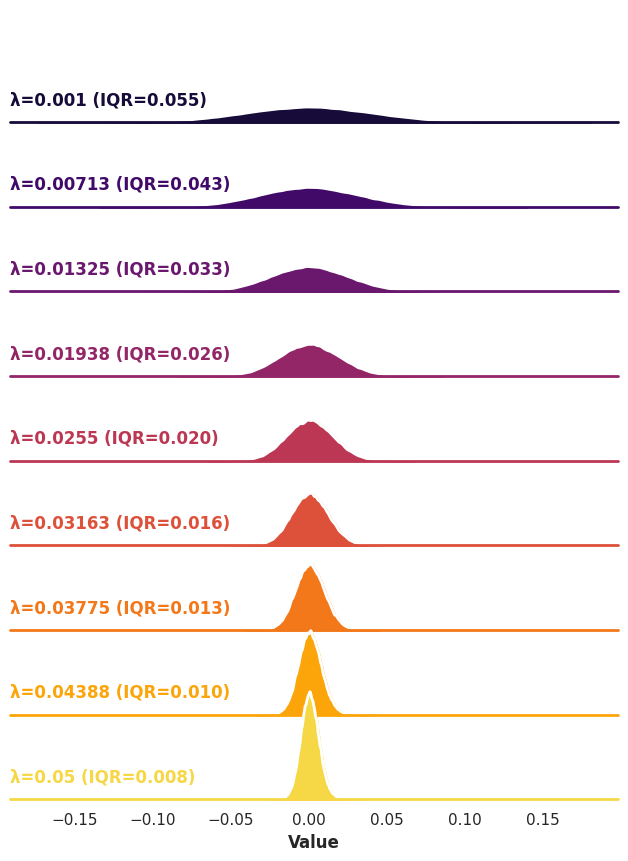

In [40]:
# Set the theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create a FacetGrid
g = sns.FacetGrid(ridge_df, row="Regularization", hue="Regularization", aspect=7, height=1, palette="inferno")

# Draw the densities
g.map(sns.kdeplot, "Value", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Value", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Calculate the IQR for each level of Regularization
iqr_dict = ridge_df.groupby('Regularization')['Value'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).to_dict()

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    iqr = iqr_dict[float(label)]  # Get the IQR for the current level of Regularization
    ax.text(0, .2, f"λ={label} (IQR={iqr:.3f})", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Value")

# Set the subplots to overlap and remove axes details that don't play well with overlap
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig("../plots/ridge_distribution_plot.pdf", dpi=500, bbox_inches='tight')

plt.show()  # Show the plot

## corr

In [93]:
def get_std(path, layer='model.layer2.0.conv1.weight'):
    path = os.path.join(path, "model_checkpoint.pth")
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    try:
        weights = checkpoint[layer].numpy().flatten()
    except:
        weights = checkpoint['conv1.weight'].numpy().flatten()

    return np.sqrt(np.mean(weights**2))#weights.std()*np.sqrt(weights.shape[0] )

df['std'] = df['path'].apply(get_std)


In [101]:
bit_p = 4
df["drop"] = df[f'bit_{bit_p}_train_accuracy'] - df["test_accuracy"]
df['model_reg'] = df.apply(lambda x: f"({x['model_name']}, {x['regularization']})", axis=1)


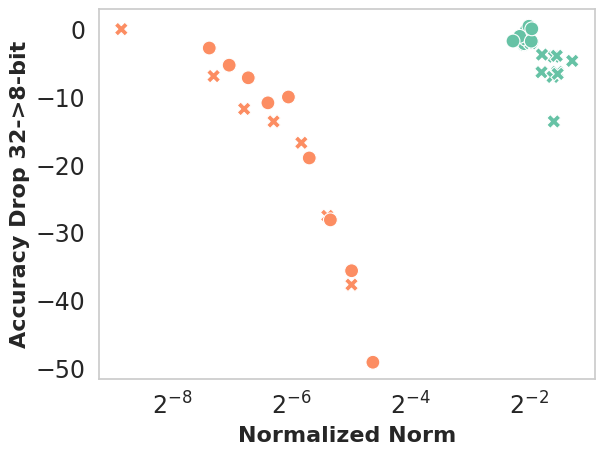

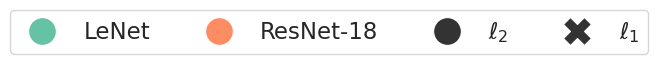

In [154]:
ax = sns.scatterplot(
    data=df[(df['std'] > 0.001) & (df['regularization_param'] > 0)], 
    x="std", 
    y="drop", 
    hue="model_name",  # Controls the color
    style="regularization",  # Controls the marker shape
    s=100  # Sets the size of the markers to a fixed value
)


# Set logarithmic scale and tick formatting
ax.set_xscale('log', base=2)
#ax.xaxis.set_major_formatter(ticker.LogFormatter())
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:g}'))
ax.tick_params(axis='x', which='minor', length=4)

# Axis labels
ax.set_xlabel("Normalized Norm", fontsize=16)
ax.set_ylabel("Accuracy Drop 32->8-bit", fontsize=16)

# Extract handles and labels for the new legend
handles, labels = ax.get_legend_handles_labels()

# Remove unwanted legend items by filtering
handles, labels = zip(*[(handle, label) for handle, label in zip(handles, labels) 
                        if label not in ["(model_name, )", "(regularization, )"]])
ax.grid(False)

# Remove the existing legend from the plot
ax.legend().remove()

# Save the scatterplot without the legend
plt.savefig("../plots/variance.pdf", dpi=500, bbox_inches='tight')

# Create a new figure for the legend
legend_fig = plt.figure(figsize=(6, 0.5))
legend_ax = legend_fig.add_subplot(111)


# Create the legend with the new combined labels
legend_ax.legend(handles[1:3] + handles[4:], ["LeNet", "ResNet-18", "$\ell_2$", "$\ell_1$"], loc='center', ncol=len(labels), markerscale=2)
legend_ax.axis('off')


legend_fig.savefig("../plots/variance_legend.pdf", dpi=500, bbox_inches='tight')




('model_name', 'lenet', 'resnet18', 'regularization', 'l2', 'l1')